Sample size: 27870

Data Summary:
                Age  Academic Pressure  Work Pressure          CGPA  \
count  2.787000e+04       2.787000e+04   2.787000e+04  2.787000e+04   
mean  -2.603029e-16      -5.621624e-17   5.098979e-18 -4.068985e-16   
std    1.000018e+00       1.000018e+00   1.000018e+00  1.000018e+00   
min   -1.594040e+00      -2.273149e+00  -9.782203e-03 -5.205319e+00   
25%   -9.826042e-01      -8.255681e-01  -9.782203e-03 -9.287598e-01   
50%   -1.673568e-01      -1.017774e-01  -9.782203e-03  7.748955e-02   
75%    8.517025e-01       6.220133e-01  -9.782203e-03  8.593724e-01   
max    6.762246e+00       1.345804e+00   1.135860e+02  1.593662e+00   

       Study Satisfaction  Job Satisfaction  Sleep Duration  Dietary Habits  \
count        2.787000e+04      2.787000e+04         27870.0    2.787000e+04   
mean         4.321385e-17     -4.079183e-18             0.0   -4.640071e-17   
std          1.000018e+00      1.000018e+00             0.0    1.000018e+00   
min       

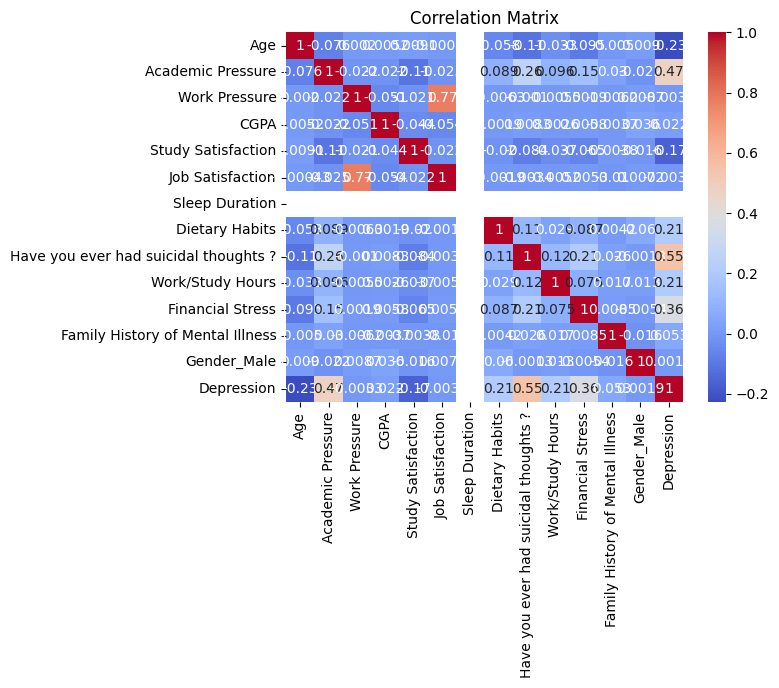

In [68]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from semopy import Model
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
# Load data
df_raw = pd.read_csv("Team01_Dataset.csv")
target_column = 'Depression'

# Verify target column exists
if target_column not in df_raw.columns:
    raise ValueError(f"Error: Target column '{target_column}' not found in the CSV.")

# Replace '?' with NaN
df_raw.replace('?', np.nan, inplace=True)

# Filter for students and drop unnecessary columns
df_raw = df_raw[df_raw['Profession'] == 'Student'].copy()
df_raw.drop(columns=['id', 'Profession'], inplace=True, errors='ignore')

# Drop rows where target is NaN
df_raw.dropna(subset=[target_column], inplace=True)

# Check sample size
print(f"Sample size: {len(df_raw)}")
if len(df_raw) < 100:
    print("Warning: Sample size is very small for SEM. Expect unstable results.")
elif len(df_raw) < 200:
    print("Warning: Sample size may be insufficient for reliable SEM.")

# Define custom cleaner (modified to avoid mean-encoding)
class CustomCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, target_column='Depression'):
        self.target_column = target_column
        self.fill_values_ = None
        self.feature_columns_ = None
        self.scaler_ = StandardScaler()

    def _clean_dataframe(self, df):
        # One-hot encode Gender
        if 'Gender' in df.columns:
            df = pd.get_dummies(df, columns=['Gender'], drop_first=True, prefix='Gender')

        # Ordinal encoding
        mappings = {
            'Dietary Habits': {"Healthy": 0, "Moderate": 1, "Unhealthy": 2, "Others": 3},
            'Have you ever had suicidal thoughts ?': {"No": 0, "Yes": 1},
            'Sleep Duration': {"More than 8 hours": 0, "7-8 hours": 1, "5-6 hours": 2, "Less than 5 hours": 3, "Others": 4},
            'Family History of Mental Illness': {"No": 0, "Yes": 1}  # Assuming Yes/No
        }
        for col, mapping in mappings.items():
            if col in df.columns:
                df[col] = df[col].map(mapping)

        # Drop City and Degree to avoid high dimensionality
        if 'City' in df.columns:
            df = df.drop(columns=['City'])
        if 'Degree' in df.columns:
            df = df.drop(columns=['Degree'])

        # Convert to numeric
        df = df.apply(pd.to_numeric, errors='coerce')
        return df

    def fit(self, X, y=None):
        df = X.copy()
        if y is not None:
            df[self.target_column] = y
        df = self._clean_dataframe(df)
        if self.target_column in df.columns:
            df.drop(columns=[self.target_column], inplace=True)
        self.fill_values_ = df.median().fillna(0)
        df.fillna(self.fill_values_, inplace=True)
        self.feature_columns_ = df.columns
        self.scaler_.fit(df)
        return self

    def transform(self, X, y=None):
        df = X.copy()
        if y is not None:
            df[self.target_column] = y
        df = self._clean_dataframe(df)
        if self.target_column in df.columns:
            df.drop(columns=[self.target_column], inplace=True)
        df.fillna(self.fill_values_, inplace=True)
        X_scaled = self.scaler_.transform(df[self.feature_columns_])
        return X_scaled

# Apply preprocessing
X = df_raw.drop(columns=[target_column])
y= df_raw[target_column]
cleaner = CustomCleaner(target_column='Depression')
cleaner.fit(X, y)
X_scaled = cleaner.transform(X)
feature_columns = cleaner.feature_columns_
df_processed = pd.DataFrame(X_scaled, columns=feature_columns)
df_processed[target_column] = y.values

# Diagnose data issues
print("\nData Summary:")
print(df_processed.describe())

# Check for zero or near-zero variance
variances = df_processed.var()
print("\nVariances:")
print(variances)
if (variances < 1e-6).any():
    print("Warning: Some variables have near-zero variance, which may cause numerical issues.")

# Check correlations
print("\nCorrelation Matrix:")
corr_matrix = df_processed.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()



In [69]:
# Rename columns for SEM compatibility
df_sem = df_processed.rename(columns={
    'Have you ever had suicidal thoughts ?': 'Have_you_ever_had_suicidal_thoughts_',
    'Family History of Mental Illness': 'Family_History_of_Mental_Illness',
    'Sleep Duration': 'Sleep_Duration',
    'Academic Pressure': 'Academic_Pressure',
    'Financial Stress': 'Financial_Stress',
    'Study Satisfaction': 'Study_Satisfaction',
    'Work/Study Hours': 'Work_Study_Hours',
    "Dietary Habits":"Dietary_Habits",
    "Job Satisfaction":"Job_Satisfaction",
    "Work Pressure":"Work_Pressure"
    
})
# df_sem = df_sem.loc[:, df_sem.var() > 1e-6]
# df_sem = df_sem.drop(columns=['Financial_Stress'])
# Ultra-simplified SEM model
model_desc = """
# Structural model
Depression ~ Academic_Pressure
Depression ~ Have_you_ever_had_suicidal_thoughts_
Depression ~ Work_Study_Hours
Stress =~ Academic_Pressure + Financial_Stress 
"""

# Fit SEM model with increased regularization
model = Model(model_desc)
try:
    model.fit(df_sem)  # Increased smoothing
    results = model.inspect()
    print("\nSEM Results:")
    print(results)
    
except np.linalg.LinAlgError as e:
    print(f"Error: Covariance matrix issue persists: {e}")
    print("Suggestions:")
    print("- Check sample size (needs at least 100–200 rows).")
    print("- Inspect df_sem.describe() for zero-variance columns.")
    print("- Drop highly correlated variables (see correlation matrix).")
    print("- Try cov_smoothing=1e-3 or higher.")


SEM Results:
                lval  op                                  rval  Estimate  \
0  Academic_Pressure   ~                                Stress  1.000000   
1         Depression   ~                     Academic_Pressure  0.171271   
2         Depression   ~  Have_you_ever_had_suicidal_thoughts_  0.217164   
3         Depression   ~                      Work_Study_Hours  0.060079   
4   Financial_Stress   ~                                Stress  0.414550   
5  Academic_Pressure  ~~                     Academic_Pressure  0.634335   
6             Stress  ~~                                Stress  0.365735   
7         Depression  ~~                            Depression  0.138023   
8   Financial_Stress  ~~                      Financial_Stress  0.936929   

   Std. Err     z-value p-value  
0         -           -       -  
1  0.002225   76.964561     0.0  
2  0.002242   96.857124     0.0  
3  0.002242   26.795917     0.0  
4  0.009774   42.411853     0.0  
5  0.007379   85.9642

In [22]:
from causallearn.search.ConstraintBased.PC import pc
import pandas as pd
import numpy as np
col_names = df_sem.columns.tolist()
cg = pc(df_sem.values, alpha=0.05, indep_test="fisherz",node_names=col_names)

  0%|          | 0/14 [00:00<?, ?it/s]

In [23]:
print(cg.G)  # Outputs the causal graph

Graph Nodes:
Age;Academic_Pressure;Work Pressure;CGPA;Study_Satisfaction;Job Satisfaction;Sleep_Duration;Dietary Habits;Have_you_ever_had_suicidal_thoughts_;Work_Study_Hours;Financial_Stress;Family_History_of_Mental_Illness;Gender_Male;Depression

Graph Edges:
1. Academic_Pressure --> Age
2. Age --> Sleep_Duration
3. Have_you_ever_had_suicidal_thoughts_ --> Age
4. Work_Study_Hours --> Age
5. Financial_Stress --> Age
6. Depression --> Age
7. CGPA --> Academic_Pressure
8. Study_Satisfaction --> Academic_Pressure
9. Job Satisfaction --> Academic_Pressure
10. Academic_Pressure --> Sleep_Duration
11. Financial_Stress --> Academic_Pressure
12. Gender_Male --> Academic_Pressure
13. Depression --> Academic_Pressure
14. Work Pressure --> CGPA
15. Work Pressure --- Job Satisfaction
16. Work Pressure --> Sleep_Duration
17. Study_Satisfaction --> CGPA
18. Job Satisfaction --> CGPA
19. CGPA --> Sleep_Duration
20. Gender_Male --> CGPA
21. Depression --> CGPA
22. Study_Satisfaction --> Sleep_Duration

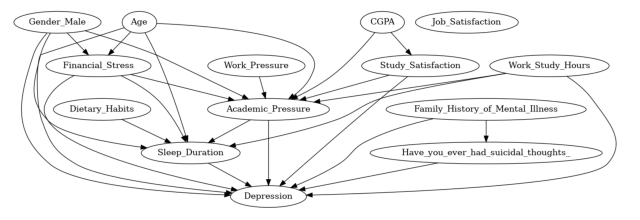

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                        
───────────────────(E[Depression])
d[Work_Study_Hours]               
Estimand assumption 1, Unconfoundedness: If U→{Work_Study_Hours} and U→Depression then P(Depression|Work_Study_Hours,,U) = P(Depression|Work_Study_Hours,)

## Realized estimand
b: Depression~Work_Study_Hours+Work_Study_Hours*Dietary_Habits+Work_Study_Hours*Have_you_ever_had_suicidal_thoughts_+Work_Study_Hours*Work_Pressure+Work_Study_Hours*Financial_Stress+Work_Study_Hours*Study_Satisfaction+Work_Study_Hours*Family_History_of_Mental_Illness+Work_Study_Hours*Gender_Male+Work_Study_Hours*Age+Work_Study_Hours*CGPA
Target units: 

## Estimate
Mean value: 0.10227154071536737
### Conditional Estimates
__categorical__Dietary_Habits  __categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Work_Pressure      __categorical__Fi

In [ ]:
import pandas as pd
from dowhy import CausalModel

graph_str = """
digraph {
    Age; Academic_Pressure; Work_Pressure; CGPA; Study_Satisfaction; Job_Satisfaction;
    Sleep_Duration; Dietary_Habits; Have_you_ever_had_suicidal_thoughts_;
    Work_Study_Hours; Financial_Stress; Family_History_of_Mental_Illness;
    Gender_Male; Depression;
    Age -> Financial_Stress; Age -> Academic_Pressure; Age -> Depression; Age -> Sleep_Duration;
    Gender_Male -> Financial_Stress; Gender_Male -> Academic_Pressure; Gender_Male -> Depression;
    Gender_Male -> Sleep_Duration;
    Financial_Stress -> Academic_Pressure; Financial_Stress -> Sleep_Duration; Financial_Stress -> Depression;
    Academic_Pressure -> Sleep_Duration; Academic_Pressure -> Depression;
    Study_Satisfaction -> Academic_Pressure; Study_Satisfaction -> Depression;
    Work_Study_Hours -> Academic_Pressure; Work_Study_Hours -> Sleep_Duration; Work_Study_Hours -> Depression;
    CGPA -> Academic_Pressure; CGPA -> Study_Satisfaction;
    Work_Pressure -> Academic_Pressure;
    Sleep_Duration -> Depression;
    Dietary_Habits -> Sleep_Duration;
    Have_you_ever_had_suicidal_thoughts_ -> Depression;
    Family_History_of_Mental_Illness -> Depression; Family_History_of_Mental_Illness -> Have_you_ever_had_suicidal_thoughts_;
}
"""

# Create causal model
model = CausalModel(
    data=df_sem,
    treatment=['Work_Study_Hours'],
    outcome='Depression',
    graph=graph_str
)
model.view_model()
# Identify effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

# Estimate effect
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    target_units="ate"
)
print(estimate)

# # Refute estimate
# refutation = model.refute_estimate(
#     identified_estimand,
#     estimate,
#     method_name="random_common_cause"
# )
refutations = [
    model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause"),
    model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter"),
]
for ref in refutations:
    print(ref)
# print(refutation)

In [ ]:
# Beware before running: cell output takes 90 mins

results = {}
treatments = [
    'Academic_Pressure',
    'CGPA',
    'Sleep_Duration',
    'Have_you_ever_had_suicidal_thoughts_',
    'Age',
    'Family_History_of_Mental_Illness'
]
# Iterate through each treatment
for treatment in treatments:
    print(f"\n=== Analyzing Treatment: {treatment} ===")
    
    try:
        # Initialize the causal model
        model = CausalModel(
            data=df_sem,
            treatment=[treatment],
            outcome='Depression',
            graph=graph_str
        )

        # Identify the causal effect
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimate the effect
        # Use propensity score matching for binary Depression, linear regression otherwise
        estimation_method = "backdoor.linear_regression"
        estimate = model.estimate_effect(
            identified_estimand,
            method_name=estimation_method,
            target_units="ate"
        )

        # Store the main estimate
        results[treatment] = {
            'estimated_effect': estimate.value,
            'estimand_type': identified_estimand.estimand_type,
            'method': estimation_method
        }

        # Print the estimate
        print(f"Estimand Type: {identified_estimand.estimand_type}")
        print(f"Estimation Method: {estimation_method}")
        print(f"Estimated Effect: {estimate.value}")
        print(f"Conditional Estimates:\n{estimate.conditional_estimates}")

        # Run refutation tests
        refutations = [
            model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause"),
            model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter"),
        ]

        # Store and print refutation results
        results[treatment]['refutations'] = []
        for i, refutation in enumerate(refutations, 1):
            ref_result = {
                'method': refutation.refutation_type,
                'new_effect': refutation.new_effect,
                'p_value': refutation.refutation_result['p_value'] 
            }
            results[treatment]['refutations'].append(ref_result)
            print(f"Refutation {i}: {ref_result['method']}")
            print(f"  New Effect: {ref_result['new_effect']}")
            print(f"  p-value: {ref_result['p_value']}")

    except Exception as e:
        print(f"Error analyzing {treatment}: {str(e)}")
        results[treatment] = {'error': str(e)}

# Summarize results
print("\n=== Summary of Causal Effects ===")
for treatment, result in results.items():
    if 'error' in result:
        print(f"{treatment}: Failed ({result['error']})")
    else:
        print(f"{treatment}:")
        print(f"  Estimated Effect: {result['estimated_effect']}")
        print(f"  Method: {result['method']}")
        print(f"  Refutations:")
        for ref in result['refutations']:
            print(f"    {ref['method']}: New Effect = {ref['new_effect']}, p-value = {ref['p_value']}")


=== Analyzing Treatment: Academic_Pressure ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.19348120300595062
Conditional Estimates:
__categorical__Dietary_Habits  __categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Family_History_of_Mental_Illness
(-1.376, -0.121]               (-1.313, 0.762]                                      (-0.969, 1.033]                                    0.202811
(-0.121, 1.132]                (-1.313, 0.762]                                      (-0.969, 1.033]                                    0.177640
(1.132, 2.386]                 (-1.313, 0.762]                                      (-0.969, 1.033]                                    0.157418
dtype: float64
Refutation 1: Refute: Add a random common cause
  New Effect: 0.19348111922927125
  p-value: 0.98
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: CGPA ===
Estimand

=== Analyzing Treatment: Academic_Pressure ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.19348120300595062
Conditional Estimates:
__categorical__Dietary_Habits  __categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Family_History_of_Mental_Illness
(-1.376, -0.121]               (-1.313, 0.762]                                      (-0.969, 1.033]                                    0.202811
(-0.121, 1.132]                (-1.313, 0.762]                                      (-0.969, 1.033]                                    0.177640
(1.132, 2.386]                 (-1.313, 0.762]                                      (-0.969, 1.033]                                    0.157418
dtype: float64
Refutation 1: Refute: Add a random common cause
  New Effect: 0.19348111922927125
  p-value: 0.98
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: CGPA ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.010505689093822435
Conditional Estimates:
__categorical__Work_Study_Hours  __categorical__Dietary_Habits  __categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Work_Pressure      __categorical__Financial_Stress  __categorical__Family_History_of_Mental_Illness  __categorical__Gender_Male  __categorical__Age
(-1.932, -1.122]                 (-1.376, -0.121]               (-1.313, 0.762]                                      (-0.010780000000000001, 113.586]  (-1.49, -0.793]                  (-0.969, 1.033]                                  (-1.123, 0.891]             (-1.595, -0.983]      0.012190
                                                                                                                                                                                                                                                                     (-0.983, -0.371]      0.015680
                                                                                                                                                                                                                                                                     (-0.371, 0.444]       0.019229
                                                                                                                                                                                                                                                                     (0.444, 1.056]        0.021210
                                                                                                                                                                                                                                                                     (1.056, 6.762]        0.023701
                                                                                                                                                                                                                                                                                             ...   
(1.036, 1.306]                   (-0.121, 1.132]                (-1.313, 0.762]                                      (-0.010780000000000001, 113.586]  (0.599, 1.295]                   (-0.969, 1.033]                                  (-1.123, 0.891]             (-1.595, -0.983]     -0.001061
                                                                                                                                                                                                                                                                     (-0.983, -0.371]      0.003172
                                                                                                                                                                                                                                                                     (-0.371, 0.444]       0.006210
                                                                                                                                                                                                                                                                     (0.444, 1.056]        0.009045
                                                                                                                                                                                                                                                                     (1.056, 6.762]        0.009918
Length: 212, dtype: float64
Refutation 1: Refute: Add a random common cause
  New Effect: 0.010505751519775229
  p-value: 0.9199999999999999
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: Sleep_Duration ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.0
Conditional Estimates:
__categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Family_History_of_Mental_Illness
(-1.313, 0.762]                                      (-0.969, 1.033]                                    0.0
dtype: float64
Refutation 1: Refute: Add a random common cause
  New Effect: -1.1102230246251566e-18
  p-value: 0.98
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: Have_you_ever_had_suicidal_thoughts_ ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.26657886228551675
Conditional Estimates:
Empty DataFrame
Columns: [Age, Academic_Pressure, Work_Pressure, CGPA, Study_Satisfaction, Job_Satisfaction, Sleep_Duration, Dietary_Habits, Have_you_ever_had_suicidal_thoughts_, Work_Study_Hours, Financial_Stress, Family_History_of_Mental_Illness, Gender_Male, Depression, __categorical__Work_Study_Hours, __categorical__Dietary_Habits, __categorical__Work_Pressure, __categorical__Financial_Stress, __categorical__Study_Satisfaction, __categorical__Gender_Male, __categorical__Age, __categorical__CGPA, __categorical__Academic_Pressure, __categorical__Sleep_Duration]
Index: []

[0 rows x 24 columns]
Refutation 1: Refute: Add a random common cause
  New Effect: 0.2665814067556427
  p-value: 1.0
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: Dietary_Habits ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.10168217550656877
Conditional Estimates:
__categorical__Work_Study_Hours  __categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Work_Pressure      __categorical__Financial_Stress  __categorical__Study_Satisfaction  __categorical__Family_History_of_Mental_Illness  __categorical__Gender_Male  __categorical__Age  __categorical__CGPA  __categorical__Academic_Pressure
(-1.932, -1.122]                 (-1.313, 0.762]                                      (-0.010780000000000001, 113.586]  (-1.49, -0.793]                  (-2.163, -0.693]                   (-0.969, 1.033]                                  (-1.123, 0.891]             (-1.595, -0.983]    (-5.206, -1.112]     (-2.274, -0.826]                    0.115965
                                                                                                                                                                                                                                                                                                                  (-0.826, -0.102]                    0.096259
                                                                                                                                                                                                                                                                                                                  (-0.102, 0.622]                     0.067325
                                                                                                                                                                                                                                                                                                                  (0.622, 1.346]                      0.068600
                                                                                                                                                                                                                                                                                             (-1.112, -0.303]     (-2.274, -0.826]                    0.109886
                                                                                                                                                                                                                                                                                                                                                        ...   
(1.036, 1.306]                   (-1.313, 0.762]                                      (-0.010780000000000001, 113.586]  (0.599, 1.295]                   (0.776, 1.511]                     (-0.969, 1.033]                                  (-1.123, 0.891]             (1.056, 6.762]      (0.345, 1.043]       (-0.826, -0.102]                    0.110912
                                                                                                                                                                                                                                                                                                                  (-0.102, 0.622]                     0.101746
                                                                                                                                                                                                                                                                                                                  (0.622, 1.346]                      0.093160
                                                                                                                                                                                                                                                                                             (1.043, 1.594]       (-2.274, -0.826]                    0.123253
                                                                                                                                                                                                                                                                                                                  (0.622, 1.346]                      0.091879
Length: 7026, dtype: float64
Refutation 1: Refute: Add a random common cause
  New Effect: 0.10168103056807237
  p-value: 0.96
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: Age ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: -0.1102079750722329
Conditional Estimates:
__categorical__Work_Study_Hours  __categorical__Dietary_Habits  __categorical__Have_you_ever_had_suicidal_thoughts_  __categorical__Work_Pressure      __categorical__Study_Satisfaction  __categorical__Family_History_of_Mental_Illness  __categorical__Gender_Male  __categorical__CGPA
(-1.932, -1.122]                 (-1.376, -0.121]               (-1.313, 0.762]                                      (-0.010780000000000001, 113.586]  (-2.163, -0.693]                   (-0.969, 1.033]                                  (-1.123, 0.891]             (-5.206, -1.112]      -0.109140
                                                                                                                                                                                                                                                                       (-1.112, -0.303]      -0.108172
                                                                                                                                                                                                                                                                       (-0.303, 0.345]       -0.106844
                                                                                                                                                                                                                                                                       (0.345, 1.043]        -0.104808
                                                                                                                                                                                                                                                                       (1.043, 1.594]        -0.105363
                                                                                                                                                                                                                                                                                                ...   
(1.036, 1.306]                   (-0.121, 1.132]                (-1.313, 0.762]                                      (-0.010780000000000001, 113.586]  (0.776, 1.511]                     (-0.969, 1.033]                                  (-1.123, 0.891]             (-5.206, -1.112]      -0.120635
                                                                                                                                                                                                                                                                       (-1.112, -0.303]      -0.117191
                                                                                                                                                                                                                                                                       (-0.303, 0.345]       -0.115646
                                                                                                                                                                                                                                                                       (0.345, 1.043]        -0.112190
                                                                                                                                                                                                                                                                       (1.043, 1.594]        -0.113926
Length: 211, dtype: float64
Refutation 1: Refute: Add a random common cause
  New Effect: -0.11020922374692528
  p-value: 0.96
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Analyzing Treatment: Family_History_of_Mental_Illness ===
Estimand Type: EstimandType.NONPARAMETRIC_ATE
Estimation Method: backdoor.linear_regression
Estimated Effect: 0.02633009240270834
Conditional Estimates:
Empty DataFrame
Columns: [Age, Academic_Pressure, Work_Pressure, CGPA, Study_Satisfaction, Job_Satisfaction, Sleep_Duration, Dietary_Habits, Have_you_ever_had_suicidal_thoughts_, Work_Study_Hours, Financial_Stress, Family_History_of_Mental_Illness, Gender_Male, Depression, __categorical__Work_Study_Hours, __categorical__Dietary_Habits, __categorical__Work_Pressure, __categorical__Financial_Stress, __categorical__Study_Satisfaction, __categorical__Gender_Male, __categorical__Age, __categorical__CGPA, __categorical__Academic_Pressure, __categorical__Sleep_Duration]
Index: []

[0 rows x 24 columns]
Refutation 1: Refute: Add a random common cause
  New Effect: 0.02632860925233163
  p-value: 0.98
Refutation 2: Refute: Use a Placebo Treatment
  New Effect: 0.0
  p-value: 1.0

=== Summary of Causal Effects ===
Academic_Pressure:
  Estimated Effect: 0.19348120300595062
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = 0.19348111922927125, p-value = 0.98
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0
CGPA:
  Estimated Effect: 0.010505689093822435
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = 0.010505751519775229, p-value = 0.9199999999999999
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0
Sleep_Duration:
  Estimated Effect: 0.0
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = -1.1102230246251566e-18, p-value = 0.98
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0
Have_you_ever_had_suicidal_thoughts_:
  Estimated Effect: 0.26657886228551675
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = 0.2665814067556427, p-value = 1.0
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0
Dietary_Habits:
  Estimated Effect: 0.10168217550656877
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = 0.10168103056807237, p-value = 0.96
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0
Age:
  Estimated Effect: -0.1102079750722329
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = -0.11020922374692528, p-value = 0.96
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0
Family_History_of_Mental_Illness:
  Estimated Effect: 0.02633009240270834
  Method: backdoor.linear_regression
  Refutations:
    Refute: Add a random common cause: New Effect = 0.02632860925233163, p-value = 0.98
    Refute: Use a Placebo Treatment: New Effect = 0.0, p-value = 1.0